In [1]:
lead_dict = {0:'I', 1:'II', 2:'III', 3:'aVR', 4:'aVL', 5:'aVF', 6:'V1', 7:'V2', 8:'V3', 9:'V4', 10:'V5', 11:'V6'}
lead_dict

{0: 'I',
 1: 'II',
 2: 'III',
 3: 'aVR',
 4: 'aVL',
 5: 'aVF',
 6: 'V1',
 7: 'V2',
 8: 'V3',
 9: 'V4',
 10: 'V5',
 11: 'V6'}

In [2]:
except_list = [2, 5, 8, 9, 10, 11]
figs = 12 - len(except_list)
figs

6

# 리드 마스킹 - 랜덤 리드

## 코드

In [3]:
import argparse
import datetime
import json
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import yaml
from torch.utils.tensorboard import SummaryWriter

import models
import util.misc as misc
from engine_pretrain import train_one_epoch
from util.dataset import build_dataset, get_dataloader
from util.misc import NativeScalerWithGradNormCount as NativeScaler
from util.optimizer import get_optimizer_from_config

from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt
%matplotlib inline
lead_dict = {0:'I', 1:'II', 2:'III', 3:'aVR', 4:'aVL', 5:'aVF', 6:'V1', 7:'V2', 8:'V3', 9:'V4', 10:'V5', 11:'V6'}

In [4]:
def parse() -> dict:
    parser = argparse.ArgumentParser('ECG self-supervised pre-training')

    parser.add_argument('--config_path',
                        default='./configs/pretrain/lead_random_recon.yaml',
                        type=str,
                        metavar='FILE',
                        help='YAML config file path')
    parser.add_argument('--output_dir',
                        default="",
                        type=str,
                        metavar='DIR',
                        help='path where to save')
    parser.add_argument('--exp_name',
                        default="",
                        type=str,
                        help='experiment name')
    parser.add_argument('--resume',
                        default="",
                        type=str,
                        metavar='PATH',
                        help='resume from checkpoint')
    parser.add_argument('--start_epoch',
                        default=0,
                        type=int,
                        metavar='N',
                        help='start epoch')

    args = parser.parse_args("")
    return args

In [5]:
args = parse()
with open(os.path.realpath(args.config_path), 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
for k, v in vars(args).items():
    if v:
        config[k] = v

In [6]:
misc.init_distributed_mode(config['ddp'])

print(yaml.dump(config, default_flow_style=False, sort_keys=False))

device = torch.device(config['device'])

# fix the seed for reproducibility
seed = config['seed'] + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

Not using distributed mode
[02:25:34.585754] seed: 0
output_dir: ./st_mem/lead_recon_test
exp_name: pretrain
resume: null
start_epoch: 0
model_name: st_mem_vit_lead_random_base_dec256d4b
device: cuda:0
ddp:
  world_size: 1
  rank: -1
  gpu: 0
  dist_url: env://
  dist_backend: nccl
  distributed: false
model:
  seq_len: 2250
  patch_size: 75
  num_leads: 12
  norm_pix_loss: true
dataset:
  filename_col: RELATIVE_FILE_PATH
  fs_col: SAMPLE_RATE
  lead: 12lead
  fs: 250
  index_dir: ./data/ptbxl
  ecg_dir: ./data/ptbxl/ecgs500
  train_csv: recon_img.csv
  train_transforms:
  - random_crop:
      crop_length: 2250
  - highpass_filter:
      fs: 250
      cutoff: 0.67
  - lowpass_filter:
      fs: 250
      cutoff: 40
  - standardize:
      axis:
      - -1
      - -2
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
train:
  epochs: 100
  accum_iter: 2
  warmup_epochs: 10
  min_lr: 0
  blr: 0.00015
  lr: null
  weight_decay: 0.01
  optimizer: adamw
  optimizer_kwargs:
    be

In [7]:
dataset_train = build_dataset(config['dataset'], split='train')
print(f'total dataset length: {len(dataset_train)}') ## dataset 크기 출력 추가 (0930)
data_loader_train = get_dataloader(dataset_train,
                                   mode='train',
                                   is_distributed=config['ddp']['distributed'],
                                   **config['dataloader'])

[02:25:34.607732] total dataset length: 1


In [8]:
model_name = config['model_name']
if model_name in models.__dict__:
    lead = models.__dict__[model_name](**config['model'])
else:
    raise ValueError(f'Unsupported model name: {model_name}')

cp = torch.load('st_mem/lead_random/pretrain/checkpoint-99.pth', map_location='cpu')
msg = lead.load_state_dict(cp['model'])
print(msg)

lead = lead.to(device)
lead

[02:25:36.593538] <All keys matched successfully>


ST_MEM_LEAD_Random(
    seq_len=2250,
    patch_size=75,
    num_leads=12,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=256,
    decoder_depth=4,
    decoder_num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06),
    norm_pix_loss=True,
)

## 시각화

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

[05:07:22.440579] Original


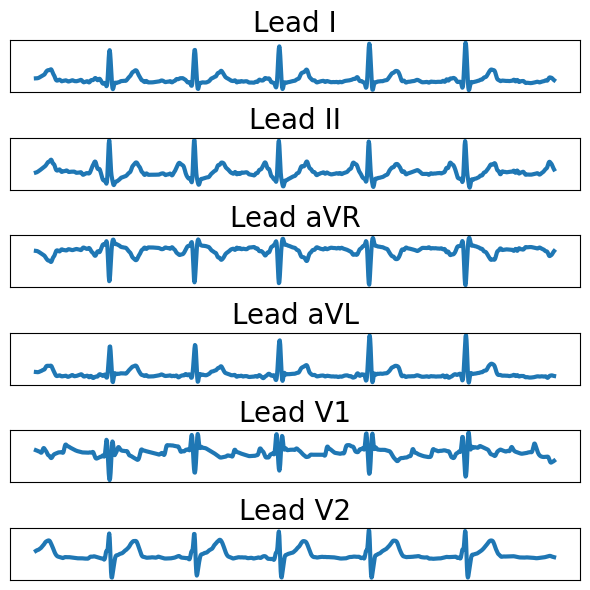

[05:07:22.679745] ----------------------------------------------------------------------------------------------------
[05:07:23.625256] Recon


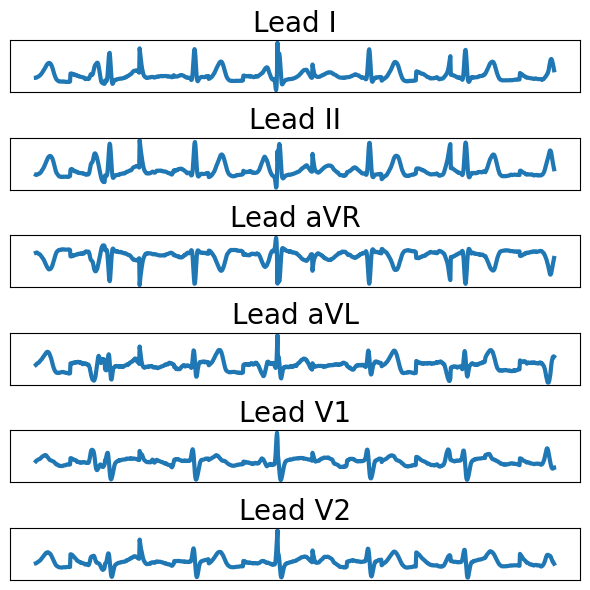

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

[05:07:23.831267] ====================================================================================================


In [9]:
# 원래
for samples in tqdm(data_loader_train):
    print('Original')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(samples[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('-'*100)
    
    
    series = samples.to(device)
    lead = lead.to(device)

    lead.eval()
    with torch.no_grad():
        latent, random_leads = lead.forward_encoder(series)
        pred = lead.forward_decoder(latent, random_leads)

    pred_ = rearrange(pred, 'b c n p -> b c (n p)')
    pred_ = pred_.detach().cpu().numpy()

    print('Recon')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(pred_[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('='*100)

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

[05:07:59.665032] Original


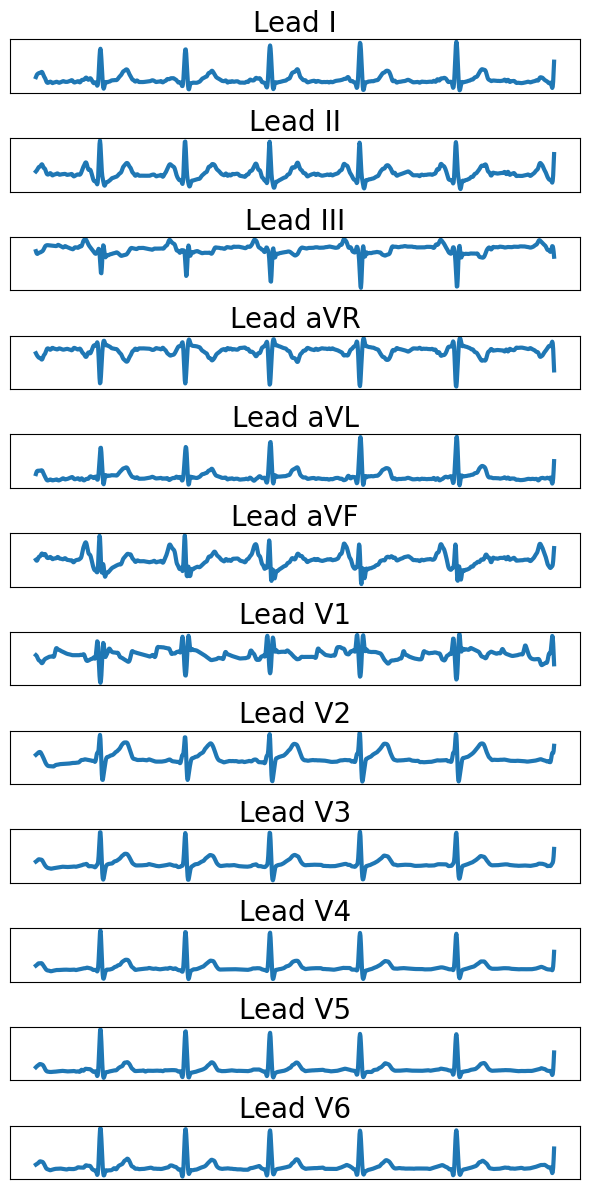

[05:08:00.273896] ----------------------------------------------------------------------------------------------------
[05:08:00.304271] Recon


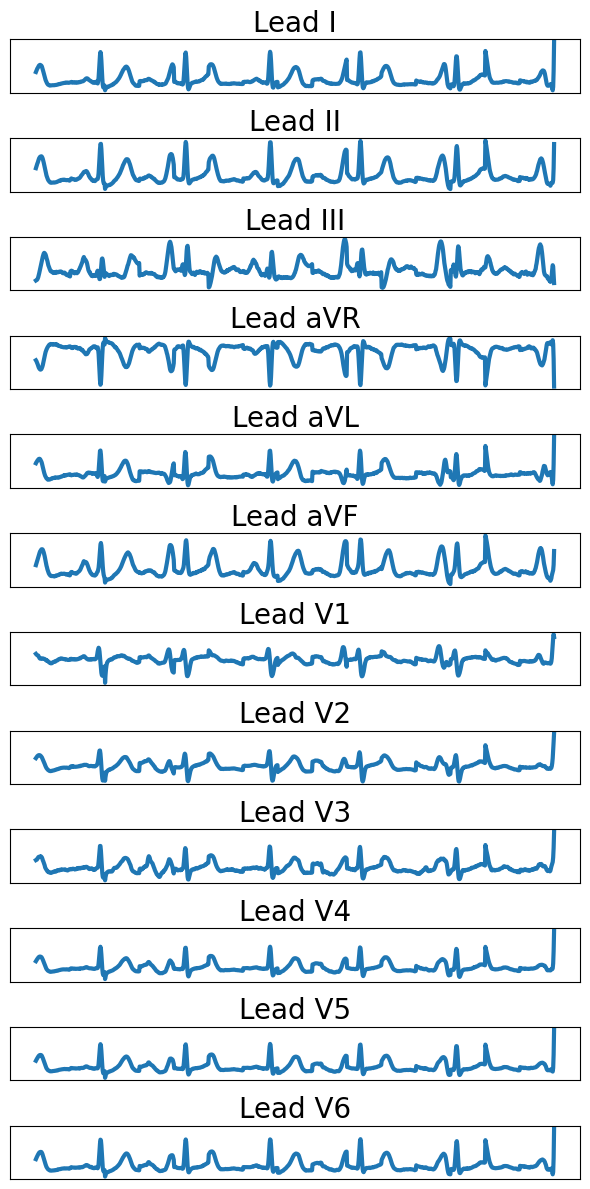

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

[05:08:00.698512] ====================================================================================================


In [12]:
for samples in tqdm(data_loader_train):
    print('Original')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(12, 1, figsize=(6, 12))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        # if k in except_list: continue
        axs[i].plot(samples[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('-'*100)
    
    
    series = samples.to(device)
    lead = lead.to(device)

    lead.eval()
    with torch.no_grad():
        latent, random_leads = lead.forward_encoder(series)
        pred = lead.forward_decoder(latent, random_leads)

    pred_ = rearrange(pred, 'b c n p -> b c (n p)')
    pred_ = pred_.detach().cpu().numpy()

    print('Recon')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(12, 1, figsize=(6, 12))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        # if k in except_list: continue
        axs[i].plot(pred_[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('='*100)

In [14]:
lead_dict[random_leads.item()-1]

'V4'

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

[02:31:13.089832] Recon
[02:31:13.089907] inpust lead: II


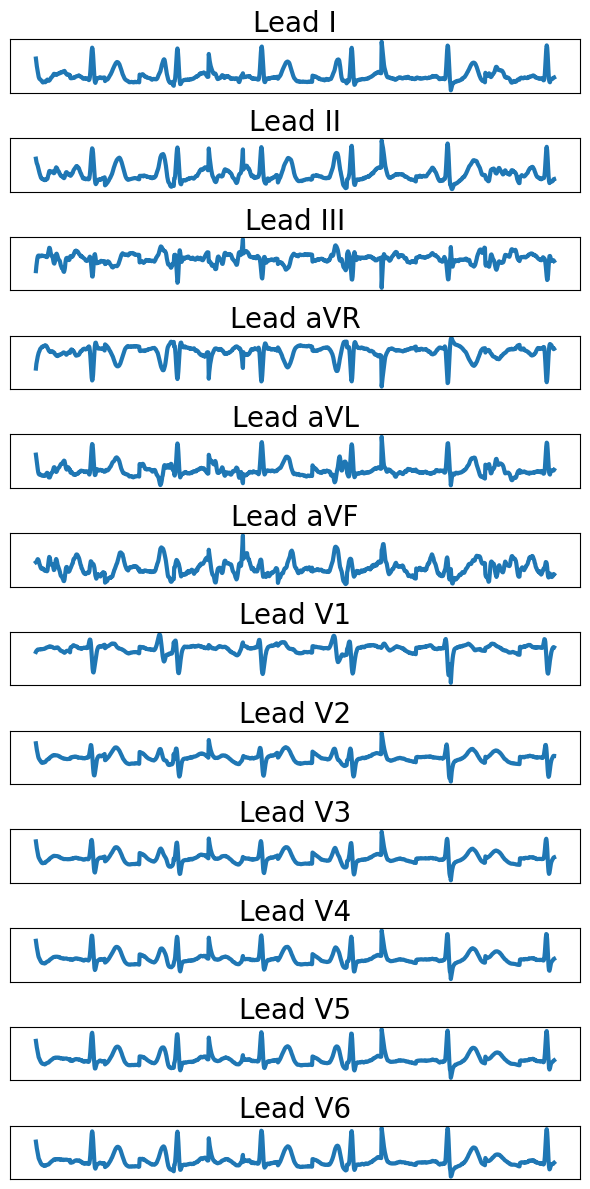

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]

[02:31:13.468317] ====================================================================================================


In [27]:
for samples in tqdm(data_loader_train):    
    series = samples.to(device)
    lead = lead.to(device)

    lead.eval()
    with torch.no_grad():
        latent, random_leads = lead.forward_encoder(series)
        pred = lead.forward_decoder(latent, random_leads)

    pred_ = rearrange(pred, 'b c n p -> b c (n p)')
    pred_ = pred_.detach().cpu().numpy()

    print('Recon')
    print(f'inpust lead: {lead_dict[random_leads.item()-1]}')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(12, 1, figsize=(6, 12))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        # if k in except_list: continue
        axs[i].plot(pred_[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('='*100)

In [28]:
import torch
mask_tmp = torch.tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.]])

[02:34:31.645231] inpust lead: II


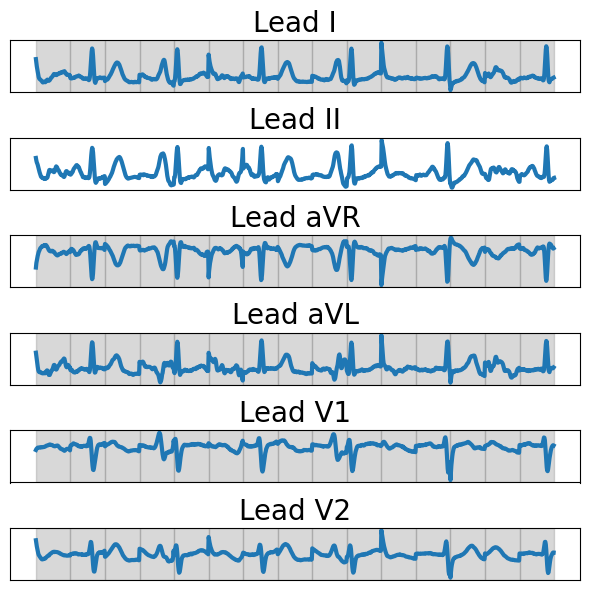

[02:34:32.093627] ====================================================================================================


In [30]:
i = 0
print(f'inpust lead: {lead_dict[random_leads.item()-1]}')
fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
for k, v in lead_dict.items():
    if k in except_list: continue
    axs[i].plot(pred_[0][k][:1125], linewidth=3)
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    if k != random_leads.item()-1:
        for idx, check in enumerate(mask_tmp[k][:15]):
            start_x = idx * 75
            end_x = start_x + 75
            axs[i].axvspan(start_x, end_x, color='gray', alpha=0.3)  # 회색 배경, 투명도 30%
        
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()
print('='*100)

# 순서 재구성

## 코드

In [8]:
import argparse
import datetime
import json
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import yaml
from torch.utils.tensorboard import SummaryWriter

import models
import util.misc as misc
from engine_pretrain import train_one_epoch
from util.dataset import build_dataset, get_dataloader
from util.misc import NativeScalerWithGradNormCount as NativeScaler
from util.optimizer import get_optimizer_from_config

from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt
%matplotlib inline
lead_dict = {0:'I', 1:'II', 2:'III', 3:'aVR', 4:'aVL', 5:'aVF', 6:'V1', 7:'V2', 8:'V3', 9:'V4', 10:'V5', 11:'V6'}

In [9]:
def parse() -> dict:
    parser = argparse.ArgumentParser('ECG self-supervised pre-training')

    parser.add_argument('--config_path',
                        default='./configs/pretrain/mix_recon.yaml',
                        type=str,
                        metavar='FILE',
                        help='YAML config file path')
    parser.add_argument('--output_dir',
                        default="",
                        type=str,
                        metavar='DIR',
                        help='path where to save')
    parser.add_argument('--exp_name',
                        default="",
                        type=str,
                        help='experiment name')
    parser.add_argument('--resume',
                        default="",
                        type=str,
                        metavar='PATH',
                        help='resume from checkpoint')
    parser.add_argument('--start_epoch',
                        default=0,
                        type=int,
                        metavar='N',
                        help='start epoch')

    args = parser.parse_args("")
    return args

In [10]:
args = parse()
with open(os.path.realpath(args.config_path), 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
for k, v in vars(args).items():
    if v:
        config[k] = v

In [11]:
misc.init_distributed_mode(config['ddp'])

print(yaml.dump(config, default_flow_style=False, sort_keys=False))

device = torch.device(config['device'])

# fix the seed for reproducibility
seed = config['seed'] + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

[04:52:16.512662] Not using distributed mode
[04:52:16.518544] [04:52:16.518534] [04:52:16.518574] seed: 0
output_dir: ./st_mem/mix_recon_test
exp_name: pretrain
resume: null
start_epoch: 0
model_name: st_mem_vit_mix_base_dec256d4b
device: cuda:0
ddp:
  world_size: 1
  rank: -1
  gpu: 0
  dist_url: env://
  dist_backend: nccl
  distributed: false
model:
  seq_len: 2250
  patch_size: 75
  num_leads: 12
  norm_pix_loss: true
dataset:
  filename_col: RELATIVE_FILE_PATH
  fs_col: SAMPLE_RATE
  lead: 12lead
  fs: 250
  index_dir: ./data/ptbxl
  ecg_dir: ./data/ptbxl/ecgs500
  train_csv: recon_img.csv
  train_transforms:
  - random_crop:
      crop_length: 2250
  - highpass_filter:
      fs: 250
      cutoff: 0.67
  - lowpass_filter:
      fs: 250
      cutoff: 40
  - standardize:
      axis:
      - -1
      - -2
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
train:
  epochs: 100
  accum_iter: 2
  warmup_epochs: 10
  min_lr: 0
  blr: 0.00015
  lr: null
  weight_decay: 0.01


In [12]:
dataset_train = build_dataset(config['dataset'], split='train')
print(f'total dataset length: {len(dataset_train)}') ## dataset 크기 출력 추가 (0930)
data_loader_train = get_dataloader(dataset_train,
                                   mode='train',
                                   is_distributed=config['ddp']['distributed'],
                                   **config['dataloader'])

[04:52:16.538291] [04:52:16.538279] [04:52:16.538367] total dataset length: 1


In [13]:
model_name = config['model_name']
if model_name in models.__dict__:
    mix = models.__dict__[model_name](**config['model'])
else:
    raise ValueError(f'Unsupported model name: {model_name}')

cp = torch.load('st_mem/mix_recon/pretrain/checkpoint-99.pth', map_location='cpu')
msg = mix.load_state_dict(cp['model'])
print(msg)

mix = mix.to(device)
mix

[04:52:18.504887] [04:52:18.504868] [04:52:18.505002] <All keys matched successfully>


ST_MEM_MIX(
    seq_len=2250,
    patch_size=75,
    num_leads=12,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=256,
    decoder_depth=4,
    decoder_num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06),
    norm_pix_loss=True,
)

## 시각화

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

[14:00:01.913336] [14:00:01.913331] [14:00:01.913413] [14:00:01.913314] [14:00:01.913439] [14:00:01.913435] [14:00:01.913459] Original


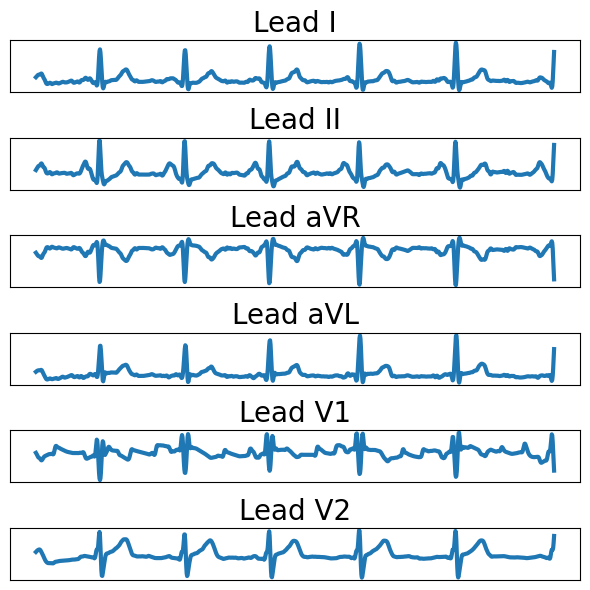

[14:00:02.385618] [14:00:02.385614] [14:00:02.385671] [14:00:02.385601] [14:00:02.385694] [14:00:02.385690] [14:00:02.385710] ----------------------------------------------------------------------------------------------------
[14:00:02.428234] [14:00:02.428230] [14:00:02.428268] [14:00:02.428214] [14:00:02.428283] [14:00:02.428281] [14:00:02.428295] Recon


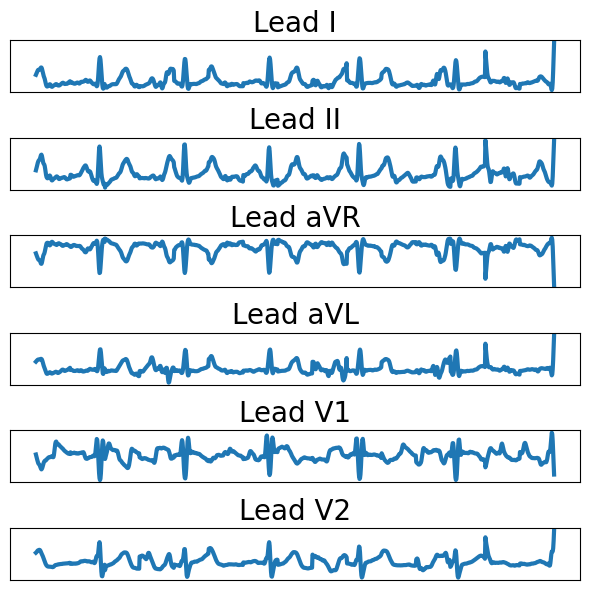

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]

[14:00:02.669824] [14:00:02.669819] [14:00:02.669869] [14:00:02.669807] [14:00:02.669890] [14:00:02.669886] [14:00:02.669906] ====================================================================================================


In [97]:
for samples in tqdm(data_loader_train):
    print('Original')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(samples[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('-'*100)
    
    
    series = samples.to(device)
    mix = mix.to(device)

    mix.eval()
    with torch.no_grad():
        latent = mix.forward_encoder(series, 0.75)
        pred = mix.forward_decoder(latent)

    pred_ = rearrange(pred, 'b c n p -> b c (n p)')
    pred_ = pred_.detach().cpu().numpy()

    print('Recon')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(pred_[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('='*100)

# ST-MEM

## 코드

In [15]:
import argparse
import datetime
import json
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import yaml
from torch.utils.tensorboard import SummaryWriter

import models
import util.misc as misc
from engine_pretrain import train_one_epoch
from util.dataset import build_dataset, get_dataloader
from util.misc import NativeScalerWithGradNormCount as NativeScaler
from util.optimizer import get_optimizer_from_config
from tqdm import tqdm
from einops import rearrange

import matplotlib.pyplot as plt
%matplotlib inline
lead_dict = {0:'I', 1:'II', 2:'III', 3:'aVR', 4:'aVL', 5:'aVF', 6:'V1', 7:'V2', 8:'V3', 9:'V4', 10:'V5', 11:'V6'}

In [16]:
def parse() -> dict:
    parser = argparse.ArgumentParser('ECG self-supervised pre-training')

    parser.add_argument('--config_path',
                        default='./configs/pretrain/st_mem_recon.yaml',
                        type=str,
                        metavar='FILE',
                        help='YAML config file path')
    parser.add_argument('--output_dir',
                        default="",
                        type=str,
                        metavar='DIR',
                        help='path where to save')
    parser.add_argument('--exp_name',
                        default="",
                        type=str,
                        help='experiment name')
    parser.add_argument('--resume',
                        default="",
                        type=str,
                        metavar='PATH',
                        help='resume from checkpoint')
    parser.add_argument('--start_epoch',
                        default=0,
                        type=int,
                        metavar='N',
                        help='start epoch')

    args = parser.parse_args("")
    return args

In [17]:
args = parse()
with open(os.path.realpath(args.config_path), 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
for k, v in vars(args).items():
    if v:
        config[k] = v

In [18]:
misc.init_distributed_mode(config['ddp'])

print(yaml.dump(config, default_flow_style=False, sort_keys=False))

device = torch.device(config['device'])

# fix the seed for reproducibility
seed = config['seed'] + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

[04:52:21.221630] [04:52:21.221616] [04:52:21.221713] Not using distributed mode
[04:52:21.227566] [04:52:21.227562] [04:52:21.227595] [04:52:21.227552] [04:52:21.227617] [04:52:21.227614] [04:52:21.227635] seed: 0
output_dir: ./st_mem/mask_recon
exp_name: pretrain
resume: null
start_epoch: 0
model_name: st_mem_vit_base_dec256d4b
device: cuda:0
ddp:
  world_size: 1
  rank: -1
  gpu: 0
  dist_url: env://
  dist_backend: nccl
  distributed: false
model:
  seq_len: 2250
  patch_size: 75
  num_leads: 12
  norm_pix_loss: true
dataset:
  filename_col: RELATIVE_FILE_PATH
  fs_col: SAMPLE_RATE
  lead: 12lead
  fs: 250
  index_dir: ./data/ptbxl
  ecg_dir: ./data/ptbxl/ecgs500
  train_csv: recon_img.csv
  train_transforms:
  - random_crop:
      crop_length: 2250
  - highpass_filter:
      fs: 250
      cutoff: 0.67
  - lowpass_filter:
      fs: 250
      cutoff: 40
  - standardize:
      axis:
      - -1
      - -2
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
train:
  epochs:

In [19]:
dataset_train = build_dataset(config['dataset'], split='train')
print(f'total dataset length: {len(dataset_train)}') ## dataset 크기 출력 추가 (0930)
data_loader_train = get_dataloader(dataset_train,
                                   is_distributed=config['ddp']['distributed'],
                                   mode='train',
                                   **config['dataloader'])

[04:52:21.242479] [04:52:21.242475] [04:52:21.242545] [04:52:21.242464] [04:52:21.242571] [04:52:21.242567] [04:52:21.242590] total dataset length: 1


In [20]:
model_name = config['model_name']
if model_name in models.__dict__:
    stmem = models.__dict__[model_name](**config['model'])
else:
    raise ValueError(f'Unsupported model name: {model_name}')

cp = torch.load('st_mem/mask_B64_RE/pretrain/checkpoint-99.pth', map_location='cpu')
msg = stmem.load_state_dict(cp['model'])
print(msg)

stmem = stmem.to(device)
stmem

[04:52:36.905201] [04:52:36.905198] [04:52:36.905302] [04:52:36.905180] [04:52:36.905320] [04:52:36.905317] [04:52:36.905334] <All keys matched successfully>


ST_MEM(
    seq_len=2250,
    patch_size=75,
    num_leads=12,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=256,
    decoder_depth=4,
    decoder_num_heads=4,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06),
    norm_pix_loss=True,
)

## 시각화

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

[14:01:32.656297] [14:01:32.656290] [14:01:32.656414] [14:01:32.656265] [14:01:32.656446] [14:01:32.656441] [14:01:32.656471] Original


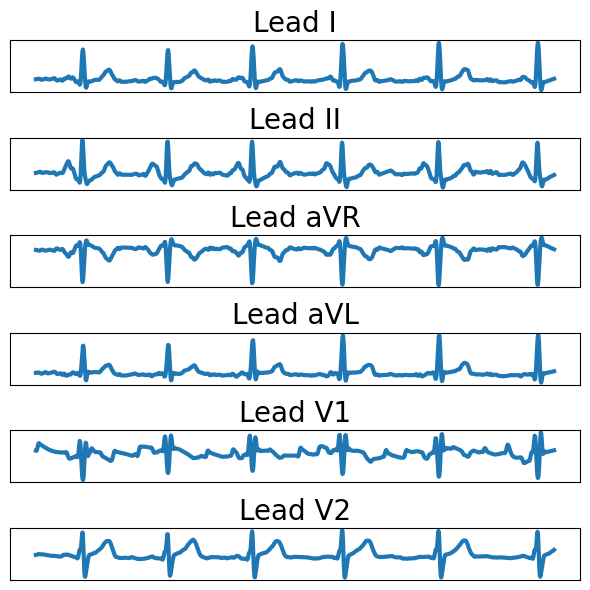

[14:01:32.888570] [14:01:32.888567] [14:01:32.888606] [14:01:32.888556] [14:01:32.888622] [14:01:32.888619] [14:01:32.888633] ----------------------------------------------------------------------------------------------------
[14:01:32.940855] [14:01:32.940852] [14:01:32.940889] [14:01:32.940839] [14:01:32.940906] [14:01:32.940903] [14:01:32.940919] Recon


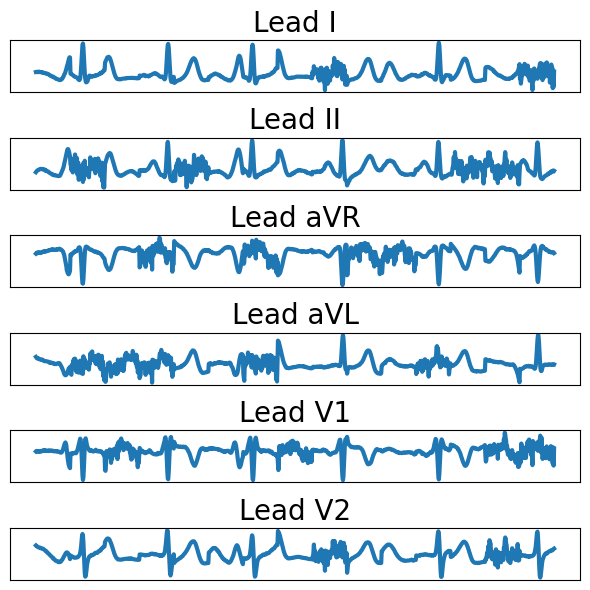

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]

[14:01:33.138872] [14:01:33.138869] [14:01:33.138909] [14:01:33.138859] [14:01:33.138925] [14:01:33.138922] [14:01:33.138936] ====================================================================================================


In [101]:
for samples in tqdm(data_loader_train):
    print('Original')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(samples[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('-'*100)
    
    
    series = samples.to(device)
    stmem = stmem.to(device)

    stmem.eval()
    with torch.no_grad():
        latent, mask, ids_restore = stmem.forward_encoder(series, 0.75)
        pred = stmem.forward_decoder(latent, ids_restore)

    pred_ = rearrange(pred, 'b c n p -> b c (n p)')
    pred_ = pred_.detach().cpu().numpy()

    print('Recon')
    # 12개의 서브플롯을 생성 (행 개수는 12로 설정, 열은 1개)
    fig, axs = plt.subplots(figs, 1, figsize=(6, figs))
    
    # 각 리드를 서브플롯으로 그리기
    i = 0
    for k, v in lead_dict.items():
        if k in except_list: continue
        axs[i].plot(pred_[0][k][:1125], linewidth=3)
        axs[i].set_title(f'Lead {v}', fontsize=20)
        axs[i].set_xticks([])  # x축 눈금 제거
        axs[i].set_yticks([])  # y축 눈금 제거
        i += 1
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()
    print('='*100)

In [104]:
mask, mask.shape

(tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
           0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
          [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
           0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
           0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
           1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
          [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
           0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
          [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
           1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],

In [105]:
mask_tmp = mask.cpu().squeeze(0)
mask_tmp

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.

In [106]:
mask_tmp.shape, mask_tmp[1].shape

(torch.Size([12, 30]), torch.Size([30]))

[14:02:31.104141] [14:02:31.104137] [14:02:31.104216] [14:02:31.104125] [14:02:31.104232] [14:02:31.104229] [14:02:31.104243] 0
[14:02:31.113330] [14:02:31.113327] [14:02:31.113358] [14:02:31.113318] [14:02:31.113373] [14:02:31.113370] [14:02:31.113384] 1
[14:02:31.120793] [14:02:31.120790] [14:02:31.120819] [14:02:31.120782] [14:02:31.120834] [14:02:31.120832] [14:02:31.120846] 3
[14:02:31.128037] [14:02:31.128035] [14:02:31.128062] [14:02:31.128027] [14:02:31.128077] [14:02:31.128074] [14:02:31.128088] 4
[14:02:31.134734] [14:02:31.134731] [14:02:31.134758] [14:02:31.134724] [14:02:31.134773] [14:02:31.134771] [14:02:31.134786] 6
[14:02:31.142035] [14:02:31.142032] [14:02:31.142059] [14:02:31.142025] [14:02:31.142074] [14:02:31.142071] [14:02:31.142085] 7


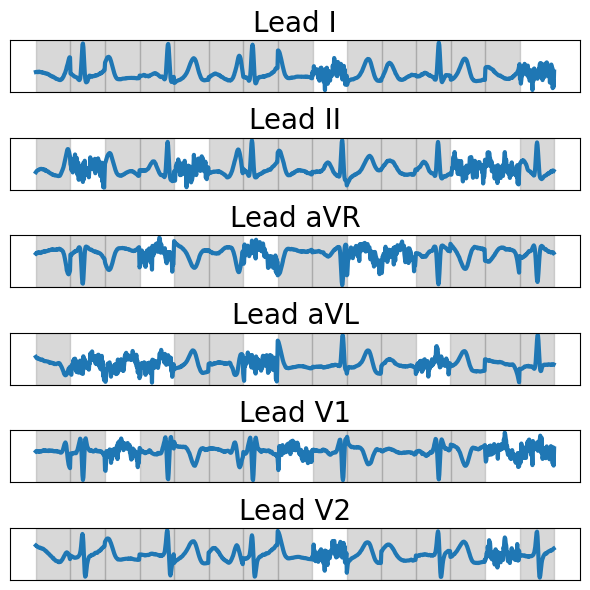

In [107]:
fig, axs = plt.subplots(figs, 1, figsize=(6, figs))

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    axs[i].plot(pred_[0][k][:1125], linewidth=3)
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    print(k)
    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        axs[i].axvspan(start_x, end_x, color='gray', alpha=0.3)  # 회색 배경, 투명도 30%
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()

[15:07:58.106302] [15:07:58.106298] [15:07:58.106428] [15:07:58.106286] [15:07:58.106445] [15:07:58.106442] [15:07:58.106457] 0
[15:07:58.118212] [15:07:58.118207] [15:07:58.118251] [15:07:58.118192] [15:07:58.118273] [15:07:58.118269] [15:07:58.118290] 1
[15:07:58.129085] [15:07:58.129080] [15:07:58.129129] [15:07:58.129066] [15:07:58.129150] [15:07:58.129147] [15:07:58.129166] 3
[15:07:58.138542] [15:07:58.138537] [15:07:58.138585] [15:07:58.138521] [15:07:58.138606] [15:07:58.138602] [15:07:58.138623] 4
[15:07:58.147189] [15:07:58.147184] [15:07:58.147232] [15:07:58.147168] [15:07:58.147253] [15:07:58.147249] [15:07:58.147269] 6
[15:07:58.156748] [15:07:58.156744] [15:07:58.156790] [15:07:58.156729] [15:07:58.156810] [15:07:58.156807] [15:07:58.156826] 7


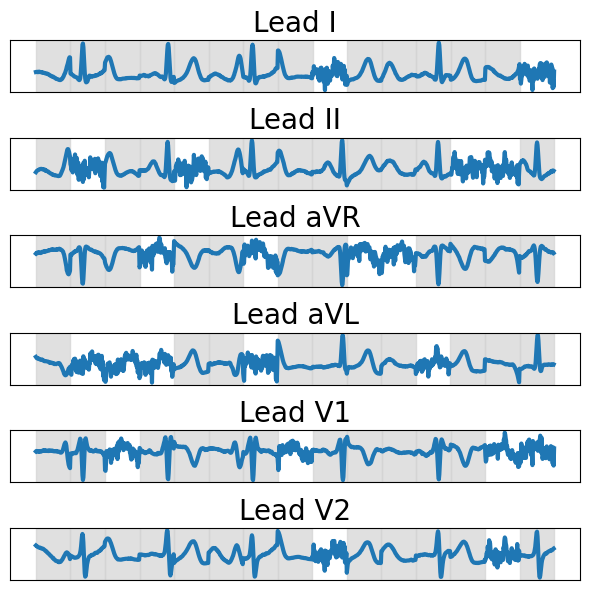

In [115]:
fig, axs = plt.subplots(figs, 1, figsize=(6, figs))

# 각 리드를 서브플롯으로 그리기
i = 0
for k, v in lead_dict.items():
    if k in except_list: continue
    axs[i].plot(pred_[0][k][:1125], linewidth=3)
    axs[i].set_title(f'Lead {v}', fontsize=20)
    axs[i].set_xticks([])  # x축 눈금 제거
    axs[i].set_yticks([])  # y축 눈금 제거

    print(k)
    for idx, check in enumerate(mask_tmp[k][:15]):
        if check == 0: continue
        start_x = idx * 75
        end_x = start_x + 75
        axs[i].axvspan(start_x, end_x, color='lightgray', edgecolor=None, alpha=0.7)  # 회색 배경, 투명도 30%
    i += 1

# 레이아웃 조정
plt.tight_layout()
plt.show()